In [1]:
import cv2
import numpy as np
import supervision as sv
from inference import get_model
from dataclasses import dataclass, field
from typing import List, Tuple

# Define ViewTransformer class
class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        if source.shape != target.shape:
            raise ValueError("Source and target must have the same shape.")
        if source.shape[1] != 2:
            raise ValueError("Source and target points must be 2D coordinates.")

        source = source.astype(np.float32)
        target = target.astype(np.float32)

        self.m, _ = cv2.findHomography(source, target)
        if self.m is None:
            raise ValueError("Homography matrix could not be calculated.")

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        if points.shape[1] != 2:
            raise ValueError("Points must be 2D coordinates.")

        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        return points.reshape(-1, 2).astype(np.float32)

# Define SoccerPitchConfiguration class
class SoccerPitchConfiguration:
    width: int = 7000  # [cm]
    length: int = 12000  # [cm]
    penalty_box_width: int = 4100  # [cm]
    penalty_box_length: int = 2015  # [cm]
    goal_box_width: int = 1832  # [cm]
    goal_box_length: int = 550  # [cm]
    centre_circle_radius: int = 915  # [cm]
    penalty_spot_distance: int = 1100  # [cm]

    @property
    def vertices(self) -> List[Tuple[int, int]]:
        return [
            (0, 0),  # 1
            (0, (self.width - self.penalty_box_width) / 2),  # 2
            (0, (self.width - self.goal_box_width) / 2),  # 3
            (0, (self.width + self.goal_box_width) / 2),  # 4
            (0, (self.width + self.penalty_box_width) / 2),  # 5
            (0, self.width),  # 6
            (self.goal_box_length, (self.width - self.goal_box_width) / 2),  # 7
            (self.goal_box_length, (self.width + self.goal_box_width) / 2),  # 8
            (self.penalty_spot_distance, self.width / 2),  # 9
            (self.penalty_box_length, (self.width - self.penalty_box_width) / 2),  # 10
            (self.penalty_box_length, (self.width - self.goal_box_width) / 2),  # 11
            (self.penalty_box_length, (self.width + self.goal_box_width) / 2),  # 12
            (self.penalty_box_length, (self.width + self.penalty_box_width) / 2),  # 13
            (self.length / 2, 0),  # 14
            (self.length / 2, self.width / 2 - self.centre_circle_radius),  # 15
            (self.length / 2, self.width / 2 + self.centre_circle_radius),  # 16
            (self.length / 2, self.width),  # 17
            (
                self.length - self.penalty_box_length,
                (self.width - self.penalty_box_width) / 2
            ),  # 18
            (
                self.length - self.penalty_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 19
            (
                self.length - self.penalty_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 20
            (
                self.length - self.penalty_box_length,
                (self.width + self.penalty_box_width) / 2
            ),  # 21
            (self.length - self.penalty_spot_distance, self.width / 2),  # 22
            (
                self.length - self.goal_box_length,
                (self.width - self.goal_box_width) / 2
            ),  # 23
            (
                self.length - self.goal_box_length,
                (self.width + self.goal_box_width) / 2
            ),  # 24
            (self.length, 0),  # 25
            (self.length, (self.width - self.penalty_box_width) / 2),  # 26
            (self.length, (self.width - self.goal_box_width) / 2),  # 27
            (self.length, (self.width + self.goal_box_width) / 2),  # 28
            (self.length, (self.width + self.penalty_box_width) / 2),  # 29
            (self.length, self.width),  # 30
            (self.length / 2 - self.centre_circle_radius, self.width / 2),  # 31
            (self.length / 2 + self.centre_circle_radius, self.width / 2),  # 32
        ]

    edges: List[Tuple[int, int]] = field(default_factory=lambda: [
        (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (7, 8),
        (10, 11), (11, 12), (12, 13), (14, 15), (15, 16),
        (16, 17), (18, 19), (19, 20), (20, 21), (23, 24),
        (25, 26), (26, 27), (27, 28), (28, 29), (29, 30),
        (1, 14), (2, 10), (3, 7), (4, 8), (5, 13), (6, 17),
        (14, 25), (18, 26), (23, 27), (24, 28), (21, 29), (17, 30)
    ])

    labels: List[str] = field(default_factory=lambda: [
        "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
        "11", "12", "13", "15", "16", "17", "18", "20", "21", "22",
        "23", "24", "25", "26", "27", "28", "29", "30", "31", "32",
        "14", "19"
    ])

    colors: List[str] = field(default_factory=lambda: [
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493", "#FF1493",
        "#FF1493", "#00BFFF", "#00BFFF", "#00BFFF", "#00BFFF", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347", "#FF6347",
        "#00BFFF", "#00BFFF"
    ])


# Load models
pitch_detection_model = get_model(
    model_id="football-field-detection-f07vi/14", 
    api_key="Syif8Lk5HpfBpj57aXEy"
)

player_detection_model = get_model(
    model_id="football-players-detection-3zvbc/10", 
    api_key="Syif8Lk5HpfBpj57aXEy"
)

# Load image
image_path = "Shot1.jpg"
frame = cv2.imread(image_path)

# Detect pitch
pitch_result = pitch_detection_model.infer(frame, confidence=0.3)[0]
pitch_keypoints = sv.KeyPoints.from_inference(pitch_result)

# Filter keypoints
filter = pitch_keypoints.confidence[0] > 0.5
pitch_keypoints.xy = pitch_keypoints.xy[0][filter][np.newaxis]
pitch_keypoints.confidence = pitch_keypoints.confidence[0][filter][np.newaxis]

# Annotate pitch keypoints
vertex_annotator = sv.VertexAnnotator(radius=12)
annotated_image = vertex_annotator.annotate(frame.copy(), pitch_keypoints)

# Detect players
player_result = player_detection_model.infer(frame, confidence=0.3)[0]
player_detections = sv.Detections.from_inference(player_result)

# Annotate players
ellipse_annotator = sv.EllipseAnnotator(thickness=2)
annotated_image = ellipse_annotator.annotate(annotated_image, player_detections)

# Transform player coordinates
CONFIG = SoccerPitchConfiguration()
transformer = ViewTransformer(
    source=pitch_keypoints.xy[0].astype(np.float32),
    target=np.array(CONFIG.vertices)[filter].astype(np.float32)
)

player_xy = player_detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
transformed_xy = transformer.transform_points(points=player_xy)

# Display and save the annotated image
cv2.imshow("Annotated Image", annotated_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imwrite("annotated_image_with_players_and_field.jpg", annotated_image)

# Print transformed player coordinates
print("Transformed player coordinates:")
print(transformed_xy)

[09/07/24 12:31:49] WARNING  Your inference package version 0.15.2 is out of date! Please upgrade to ]8;id=981397;file://c:\Users\Miguel\AppData\Local\Programs\Python\Python311\Lib\site-packages\inference\core\__init__.py\__init__.py]8;;\:]8;id=340562;file://c:\Users\Miguel\AppData\Local\Programs\Python\Python311\Lib\site-packages\inference\core\__init__.py#35\35]8;;\
                             version 0.18.1 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Transformed player coordinates:
[[3152.2986 3787.8726]
 [2338.8396 5250.699 ]
 [3535.97   4131.06  ]
 [2335.9785 3809.852 ]
 [2416.6228 2051.6028]
 [2753.0083 1780.2438]
 [3115.9592 1957.3218]
 [2412.532  2624.5195]
 [3664.0115 3144.366 ]
 [4213.291  4014.767 ]
 [ 528.3451 3628.3267]
 [2306.379  4569.3906]
 [3591.2488 2993.6704]
 [2540.4617 4446.2104]
 [3328.8767 4095.683 ]
 [2609.2778  893.9352]]


Detection counts:
2: 13
3: 1
1: 1
0: 1


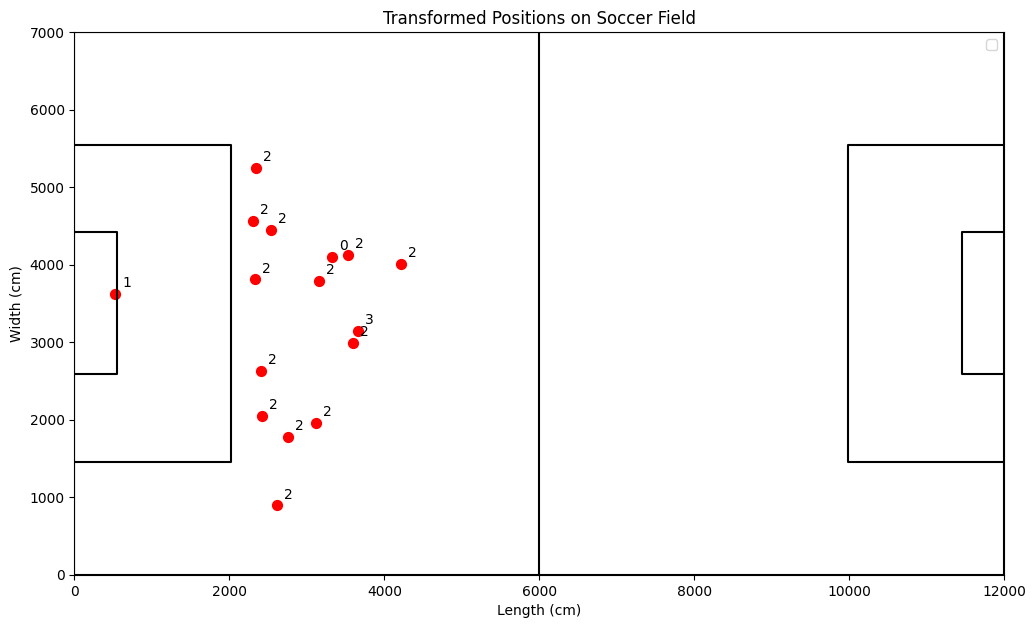

<Figure size 640x480 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


# Create a new figure for the soccer field visualization
plt.figure(figsize=(12, 8))

# Draw the soccer field
plt.plot([0, CONFIG.length, CONFIG.length, 0, 0], [0, 0, CONFIG.width, CONFIG.width, 0], 'k-')
plt.plot([CONFIG.length/2, CONFIG.length/2], [0, CONFIG.width], 'k-')
plt.plot([0, CONFIG.penalty_box_length, CONFIG.penalty_box_length, 0], 
         [(CONFIG.width - CONFIG.penalty_box_width)/2, (CONFIG.width - CONFIG.penalty_box_width)/2, 
          (CONFIG.width + CONFIG.penalty_box_width)/2, (CONFIG.width + CONFIG.penalty_box_width)/2], 'k-')
plt.plot([CONFIG.length, CONFIG.length - CONFIG.penalty_box_length, CONFIG.length - CONFIG.penalty_box_length, CONFIG.length], 
         [(CONFIG.width - CONFIG.penalty_box_width)/2, (CONFIG.width - CONFIG.penalty_box_width)/2, 
          (CONFIG.width + CONFIG.penalty_box_width)/2, (CONFIG.width + CONFIG.penalty_box_width)/2], 'k-')
plt.plot([0, CONFIG.goal_box_length, CONFIG.goal_box_length, 0], 
         [(CONFIG.width - CONFIG.goal_box_width)/2, (CONFIG.width - CONFIG.goal_box_width)/2, 
          (CONFIG.width + CONFIG.goal_box_width)/2, (CONFIG.width + CONFIG.goal_box_width)/2], 'k-')
plt.plot([CONFIG.length, CONFIG.length - CONFIG.goal_box_length, CONFIG.length - CONFIG.goal_box_length, CONFIG.length], 
         [(CONFIG.width - CONFIG.goal_box_width)/2, (CONFIG.width - CONFIG.goal_box_width)/2, 
          (CONFIG.width + CONFIG.goal_box_width)/2, (CONFIG.width + CONFIG.goal_box_width)/2], 'k-')

# Define colors for different types of detections
color_map = {
    'player': 'blue',
    'ball': 'orange',
    'referee': 'yellow',
    'goalkeeper': 'green',
    'other': 'red'
}

# Count the occurrences of each class
class_counts = Counter(player_detections.class_id)
print("Detection counts:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Plot the transformed coordinates with different colors and labels
for i, (x, y) in enumerate(transformed_xy):
    detection_class = player_detections.class_id[i]
    color = color_map.get(detection_class, 'red')  # Default to red if class not in color_map
    plt.scatter(x, y, c=color, s=50)
    plt.annotate(detection_class, (x, y), xytext=(5, 5), textcoords='offset points')

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f"{class_name} ({class_counts[class_name]})",
                   markerfacecolor=color, markersize=10)
                   for class_name, color in color_map.items() if class_name in class_counts]
plt.legend(handles=legend_elements, loc='upper right')

# Set the aspect ratio to equal for proper field proportions
plt.gca().set_aspect('equal', adjustable='box')

# Set labels and title
plt.xlabel('Length (cm)')
plt.ylabel('Width (cm)')
plt.title('Transformed Positions on Soccer Field')

# Set the plot limits to match the field dimensions
plt.xlim(0, CONFIG.length)
plt.ylim(0, CONFIG.width)

# Show the plot
plt.show()

# Optionally, save the plot
plt.savefig('transformed_positions_labeled.png')

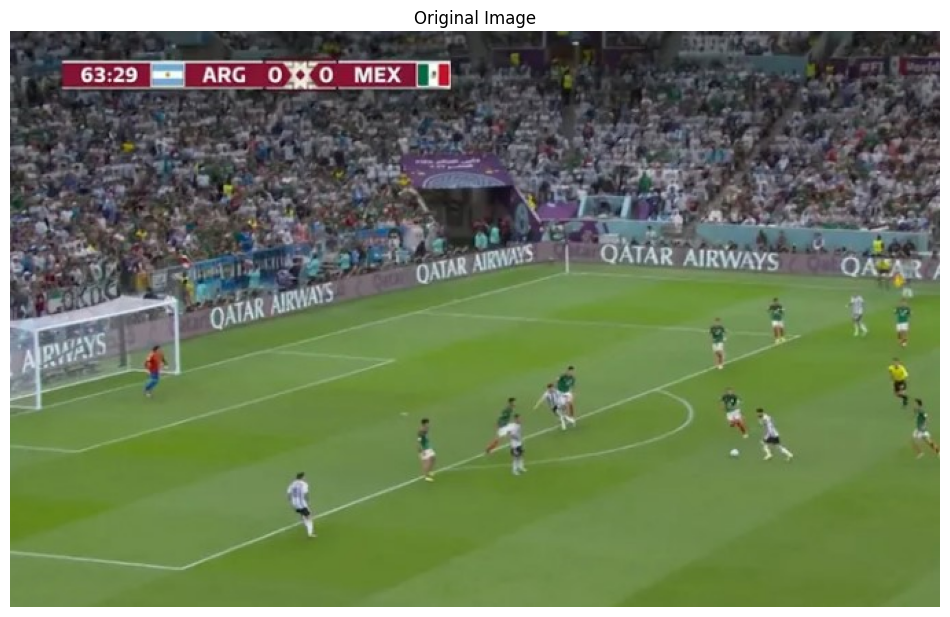

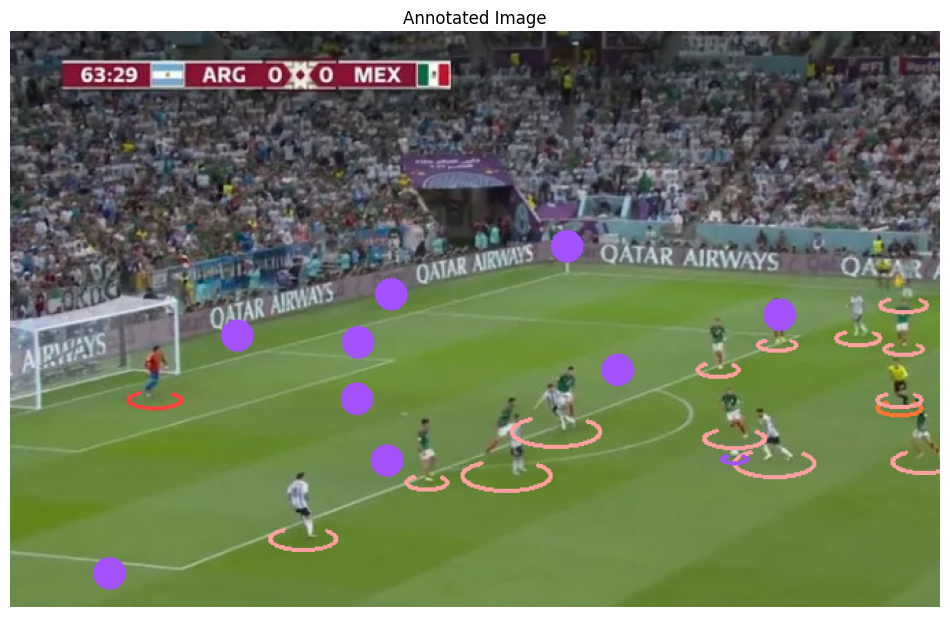

In [66]:
# Display the original image
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

# Display the annotated image
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title('Annotated Image')
plt.axis('off')
plt.show()
